In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) 

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [4]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

!ls drive/img


driver_imgs_list.csv  test   test (1)  testdata.hdf5  traindata.hdf5
my_drive	      test1  test2     train


I alredy resized all images in my local jupyter to (64,64,3) and uploaded the folders to google drive to use Colab GPU.

In [0]:
import matplotlib.pyplot as plt
import numpy 
import cv2
import os
import glob
import time
import numpy as np
%matplotlib inline

In [7]:
train_file = sorted(glob.glob('drive/img/train/**/*.jpg'))
len(train_file)

22504

In [8]:
print(train_file[0])

drive/img/train/c0/img_100026.jpg


In [9]:
c0 = plt.imread(train_file[0])
print(c0.shape)

(64, 64, 3)


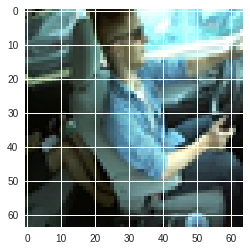

In [10]:
plt.imshow(c0)

In [0]:
# import traindata from the local 
# The code I used:
# X_train = []
# y_train = []
#for fpath in train_file:
#    img = plt.imread(fpath)
#    X_train.append(img)
#    y_train.append(int(fpath.split('/')[5].split('\\')[1][1:]))
##
# y_train = np.array(y_train, dtype = 'float32')
# X_train = np.array(X_train, dtype = 'float32')
#from keras.utils import to_categorical
#y_train = to_categorical(y_train)
#print(x_train.shape, y_train.shape)

import h5py
with h5py.File('drive/img/traindata.hdf5','r') as f:
    X_train = f['X'][()] 
    y_train = f['Y'][()]

In [11]:
print(X_train.shape, y_train.shape)

(22424, 64, 64, 3) (22424, 10)


In [0]:
X_train = X_train / 255

In [0]:
# Split the train images to test and training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.optimizers import Adam

Using TensorFlow backend.


In [34]:
#Linear model
L_model = Sequential([
        BatchNormalization(axis=-1, input_shape=(64, 64, 3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
L_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
L_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 2, batch_size = 65, verbose = 2)

Train on 17939 samples, validate on 4485 samples
Epoch 1/2
 - 4s - loss: 0.7865 - acc: 0.7955 - val_loss: 0.2596 - val_acc: 0.9260
Epoch 2/2
 - 3s - loss: 0.1746 - acc: 0.9515 - val_loss: 0.1412 - val_acc: 0.9590


In [35]:
L_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
flatten_6 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                122890    
Total params: 122,902
Trainable params: 122,896
Non-trainable params: 6
_________________________________________________________________


In [32]:
def bilayer_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, 5, input_shape=(64, 64, 3), activation= 'relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, 3, activation= 'relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation= 'relu' ))
    model.add(Dense(50, activation= 'relu' ))
    model.add(Dense(10, activation= 'softmax' ))
  
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model
    
# build the model
model = bilayer_model()
log = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200,verbose=2)


Train on 17939 samples, validate on 4485 samples
Epoch 1/20
 - 4s - loss: 1.3179 - acc: 0.5045 - val_loss: 14.0725 - val_acc: 0.0952
Epoch 2/20
 - 4s - loss: 0.3849 - acc: 0.8851 - val_loss: 14.4958 - val_acc: 0.0961
Epoch 3/20
 - 4s - loss: 0.1720 - acc: 0.9553 - val_loss: 14.5099 - val_acc: 0.0990
Epoch 4/20
 - 4s - loss: 0.0959 - acc: 0.9753 - val_loss: 14.5195 - val_acc: 0.0988
Epoch 5/20
 - 4s - loss: 0.0707 - acc: 0.9806 - val_loss: 14.5134 - val_acc: 0.0990
Epoch 6/20
 - 4s - loss: 0.0514 - acc: 0.9862 - val_loss: 14.5186 - val_acc: 0.0990
Epoch 7/20
 - 4s - loss: 0.0351 - acc: 0.9905 - val_loss: 14.5194 - val_acc: 0.0990
Epoch 8/20
 - 4s - loss: 0.0316 - acc: 0.9899 - val_loss: 14.5197 - val_acc: 0.0990
Epoch 9/20
 - 4s - loss: 0.0266 - acc: 0.9914 - val_loss: 14.5189 - val_acc: 0.0992
Epoch 10/20
 - 4s - loss: 0.0220 - acc: 0.9944 - val_loss: 14.5183 - val_acc: 0.0990
Epoch 11/20
 - 4s - loss: 0.0160 - acc: 0.9952 - val_loss: 14.5204 - val_acc: 0.0990
Epoch 12/20
 - 4s - loss:

Train on 17939 samples, validate on 4485 samples
Epoch 1/20
 - 4s - loss: 1.5142 - acc: 0.4621 - val_loss: 0.6486 - val_acc: 0.8252
Epoch 2/20
 - 4s - loss: 0.4371 - acc: 0.8733 - val_loss: 0.2117 - val_acc: 0.9485
Epoch 3/20
 - 4s - loss: 0.2069 - acc: 0.9443 - val_loss: 0.1280 - val_acc: 0.9648
Epoch 4/20
 - 4s - loss: 0.1281 - acc: 0.9648 - val_loss: 0.0856 - val_acc: 0.9744
Epoch 5/20
 - 4s - loss: 0.0914 - acc: 0.9744 - val_loss: 0.0680 - val_acc: 0.9808
Epoch 6/20
 - 4s - loss: 0.0673 - acc: 0.9801 - val_loss: 0.0463 - val_acc: 0.9895
Epoch 7/20
 - 4s - loss: 0.0572 - acc: 0.9828 - val_loss: 0.0506 - val_acc: 0.9853
Epoch 8/20
 - 4s - loss: 0.0448 - acc: 0.9863 - val_loss: 0.0438 - val_acc: 0.9873
Epoch 9/20
 - 4s - loss: 0.0319 - acc: 0.9900 - val_loss: 0.0410 - val_acc: 0.9889
Epoch 10/20
 - 4s - loss: 0.0277 - acc: 0.9919 - val_loss: 0.0401 - val_acc: 0.9891
Epoch 11/20
 - 4s - loss: 0.0279 - acc: 0.9915 - val_loss: 0.0329 - val_acc: 0.9906
Epoch 12/20
 - 4s - loss: 0.0254 - a

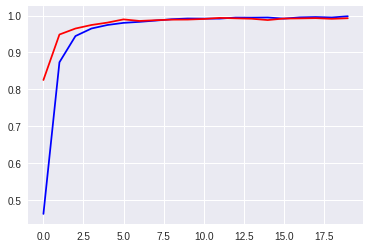

In [37]:
def bilayer_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, 5, input_shape=(64, 64, 3), activation= 'relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, 3, activation= 'relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation= 'relu' ))
    model.add(Dense(50, activation= 'relu' ))
    model.add(Dense(10, activation= 'softmax' ))
  
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model
    
# build the model
model = bilayer_model()
# Fit the model
log = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200,verbose=2)

# Simple model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

# plot of accuracy and validaton accuracy
plt.plot(log.history['acc'],'b') 
plt.plot(log.history['val_acc'],'r')
plt.show()

Train on 17939 samples, validate on 4485 samples
Epoch 1/50
 - 10s - loss: 1.8552 - acc: 0.3671 - val_loss: 1.2254 - val_acc: 0.6821
Epoch 2/50
 - 8s - loss: 1.2764 - acc: 0.6268 - val_loss: 0.9197 - val_acc: 0.8247
Epoch 3/50
 - 8s - loss: 0.9954 - acc: 0.7586 - val_loss: 0.6800 - val_acc: 0.8836
Epoch 4/50
 - 8s - loss: 0.8180 - acc: 0.8197 - val_loss: 0.5032 - val_acc: 0.9249
Epoch 5/50
 - 8s - loss: 0.6828 - acc: 0.8604 - val_loss: 0.4935 - val_acc: 0.9182
Epoch 6/50
 - 8s - loss: 0.5799 - acc: 0.8878 - val_loss: 0.3640 - val_acc: 0.9516
Epoch 7/50
 - 8s - loss: 0.5016 - acc: 0.9082 - val_loss: 0.2745 - val_acc: 0.9737
Epoch 8/50
 - 8s - loss: 0.4419 - acc: 0.9217 - val_loss: 0.2533 - val_acc: 0.9735
Epoch 9/50
 - 8s - loss: 0.3961 - acc: 0.9339 - val_loss: 0.1968 - val_acc: 0.9773
Epoch 10/50
 - 8s - loss: 0.3549 - acc: 0.9392 - val_loss: 0.1729 - val_acc: 0.9826
Epoch 11/50
 - 8s - loss: 0.3240 - acc: 0.9444 - val_loss: 0.1344 - val_acc: 0.9831
Epoch 12/50
 - 8s - loss: 0.2949 - 

 - 8s - loss: 0.0872 - acc: 0.9861 - val_loss: 0.0425 - val_acc: 0.9915
Epoch 35/50
 - 8s - loss: 0.0860 - acc: 0.9846 - val_loss: 0.0287 - val_acc: 0.9935
Epoch 36/50
 - 8s - loss: 0.0832 - acc: 0.9867 - val_loss: 0.0275 - val_acc: 0.9940
Epoch 37/50
 - 8s - loss: 0.0803 - acc: 0.9857 - val_loss: 0.0293 - val_acc: 0.9933
Epoch 38/50
 - 8s - loss: 0.0795 - acc: 0.9862 - val_loss: 0.0289 - val_acc: 0.9935
Epoch 39/50
 - 8s - loss: 0.0737 - acc: 0.9877 - val_loss: 0.0239 - val_acc: 0.9946
Epoch 40/50
 - 8s - loss: 0.0728 - acc: 0.9885 - val_loss: 0.0210 - val_acc: 0.9946
Epoch 41/50
 - 8s - loss: 0.0714 - acc: 0.9875 - val_loss: 0.0210 - val_acc: 0.9951
Epoch 42/50
 - 8s - loss: 0.0716 - acc: 0.9866 - val_loss: 0.0267 - val_acc: 0.9942
Epoch 43/50
 - 8s - loss: 0.0653 - acc: 0.9894 - val_loss: 0.0211 - val_acc: 0.9949
Epoch 44/50
 - 8s - loss: 0.0676 - acc: 0.9870 - val_loss: 0.0281 - val_acc: 0.9920
Epoch 45/50
 - 8s - loss: 0.0642 - acc: 0.9890 - val_loss: 0.0227 - val_acc: 0.9942
Epoc

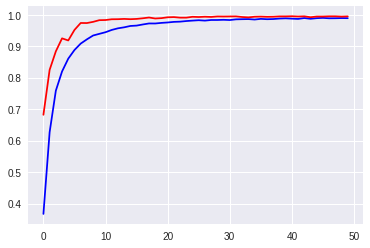

In [41]:
def CNN_model1(lr):
    # create model
    model = Sequential()
    
    model.add(Conv2D(16, 3, input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(16, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(125))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    

    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    adam = Adam(lr=lr)
    model.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])
    return model

# build the model
model = CNN_model1(0.001)

# Fit the model
t0=time.time()
log = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Simple model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

plt.plot(log.history['acc'],'b') 
plt.plot(log.history['val_acc'],'r')
plt.show()

The model I made with learning rate (0.001) worked well. So I wanted to see results with different learning rates.

lr= 0.01 400.6098413467407  seconds
CNN Error: 0.60%


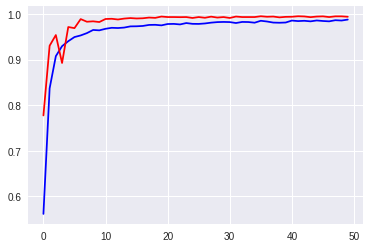

lr= 0.001 403.92528891563416  seconds
CNN Error: 0.69%


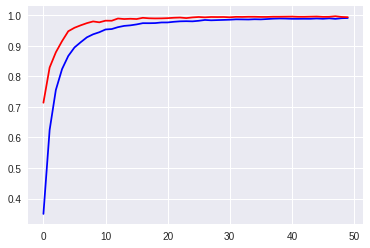

lr= 0.0001 403.7007966041565  seconds
CNN Error: 2.65%


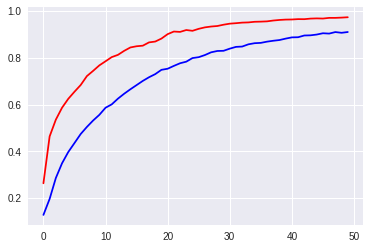

lr= 1e-05 405.3490273952484  seconds
CNN Error: 38.97%


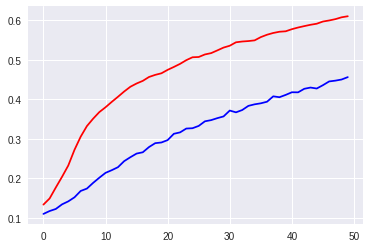

In [42]:
for lr in [0.01,0.001,0.0001,0.00001]:
    # build the model
    model = CNN_model1(lr)

    # Fit the model
    t0=time.time()
    log = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200, verbose=0)
    t1=time.time()
    print('lr=',lr, t1-t0," seconds")

    # Simple model evaluation
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("CNN Error: %.2f%%" % (100-scores[1]*100))

    plt.plot(log.history['acc'],'b') 
    plt.plot(log.history['val_acc'],'r')
    plt.show()

Train on 17939 samples, validate on 4485 samples
Epoch 1/20
 - 18s - loss: 2.3610 - acc: 0.1649 - val_loss: 2.0615 - val_acc: 0.2069
Epoch 2/20
 - 16s - loss: 1.8265 - acc: 0.3408 - val_loss: 1.6333 - val_acc: 0.4713
Epoch 3/20
 - 15s - loss: 1.6332 - acc: 0.4198 - val_loss: 1.6130 - val_acc: 0.4515
Epoch 4/20
 - 15s - loss: 1.4671 - acc: 0.4914 - val_loss: 1.3499 - val_acc: 0.5614
Epoch 5/20
 - 15s - loss: 1.3189 - acc: 0.5500 - val_loss: 1.3770 - val_acc: 0.5425
Epoch 6/20
 - 15s - loss: 1.1789 - acc: 0.6090 - val_loss: 1.0524 - val_acc: 0.6656
Epoch 7/20
 - 15s - loss: 1.0433 - acc: 0.6525 - val_loss: 0.7850 - val_acc: 0.7645
Epoch 8/20
 - 15s - loss: 0.9400 - acc: 0.6930 - val_loss: 0.9113 - val_acc: 0.7295
Epoch 9/20
 - 15s - loss: 0.8562 - acc: 0.7232 - val_loss: 0.5675 - val_acc: 0.8419
Epoch 10/20
 - 14s - loss: 0.7959 - acc: 0.7421 - val_loss: 0.5606 - val_acc: 0.8343
Epoch 11/20
 - 16s - loss: 0.7341 - acc: 0.7597 - val_loss: 0.6185 - val_acc: 0.8261
Epoch 12/20
 - 16s - loss

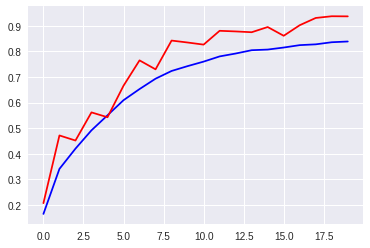

In [43]:
def CNN_model2():
    # create model
    model = Sequential()
    
    model.add(Conv2D(16, 3, input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(250))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    

    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    adam = Adam(lr=0.001)
    model.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])
    return model

# build the model
model = CNN_model2()

# Fit the model
t0=time.time()
log = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Simple model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

plt.plot(log.history['acc'],'b') 
plt.plot(log.history['val_acc'],'r')
plt.show()

Train on 17939 samples, validate on 4485 samples
Epoch 1/20
 - 16s - loss: 2.3477 - acc: 0.1711 - val_loss: 1.8714 - val_acc: 0.2821
Epoch 2/20
 - 12s - loss: 1.8373 - acc: 0.3314 - val_loss: 1.8279 - val_acc: 0.3516
Epoch 3/20
 - 12s - loss: 1.6591 - acc: 0.4158 - val_loss: 1.5540 - val_acc: 0.4747
Epoch 4/20
 - 12s - loss: 1.5089 - acc: 0.4795 - val_loss: 1.3816 - val_acc: 0.5659
Epoch 5/20
 - 12s - loss: 1.3522 - acc: 0.5428 - val_loss: 1.2425 - val_acc: 0.6065
Epoch 6/20
 - 12s - loss: 1.2245 - acc: 0.5925 - val_loss: 1.1015 - val_acc: 0.6598
Epoch 7/20
 - 12s - loss: 1.1031 - acc: 0.6404 - val_loss: 1.2901 - val_acc: 0.5897
Epoch 8/20
 - 12s - loss: 0.9991 - acc: 0.6771 - val_loss: 0.9250 - val_acc: 0.7164
Epoch 9/20
 - 12s - loss: 0.8937 - acc: 0.7133 - val_loss: 1.0646 - val_acc: 0.6718
Epoch 10/20
 - 12s - loss: 0.8169 - acc: 0.7366 - val_loss: 0.6803 - val_acc: 0.8116
Epoch 11/20
 - 12s - loss: 0.7607 - acc: 0.7599 - val_loss: 0.5339 - val_acc: 0.8319
Epoch 12/20
 - 12s - loss

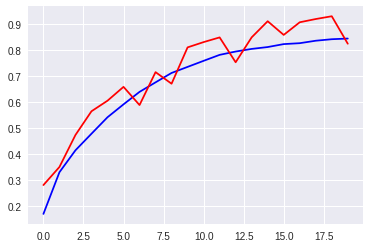

In [44]:
def CNN_model3():
    # create model
    model = Sequential()
    
    model.add(Conv2D(16, 3, input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(250))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    

    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    adam = Adam(lr=0.001)
    model.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])
    return model

# build the model
model = CNN_model3()

# Fit the model
t0=time.time()
log = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Simple model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

plt.plot(log.history['acc'],'b') 
plt.plot(log.history['val_acc'],'r')
plt.show()

Based on CNN_modle 1, I made a final model to increase the accuracy rate and decrease the CNN error rate. I changed third convolution layer to (64, (3,3)) and set the higher Dense layer.

Train on 17939 samples, validate on 4485 samples
Epoch 1/50
 - 11s - loss: 1.5448 - acc: 0.5128 - val_loss: 0.9716 - val_acc: 0.8009
Epoch 2/50
 - 9s - loss: 0.9267 - acc: 0.8021 - val_loss: 0.5654 - val_acc: 0.9173
Epoch 3/50
 - 8s - loss: 0.6807 - acc: 0.8900 - val_loss: 0.4006 - val_acc: 0.9434
Epoch 4/50
 - 9s - loss: 0.5379 - acc: 0.9234 - val_loss: 0.3046 - val_acc: 0.9715
Epoch 5/50
 - 9s - loss: 0.4394 - acc: 0.9473 - val_loss: 0.2360 - val_acc: 0.9770
Epoch 6/50
 - 9s - loss: 0.3736 - acc: 0.9546 - val_loss: 0.1822 - val_acc: 0.9844
Epoch 7/50
 - 8s - loss: 0.3227 - acc: 0.9640 - val_loss: 0.1456 - val_acc: 0.9873
Epoch 8/50
 - 9s - loss: 0.2799 - acc: 0.9705 - val_loss: 0.1398 - val_acc: 0.9866
Epoch 9/50
 - 9s - loss: 0.2479 - acc: 0.9740 - val_loss: 0.1291 - val_acc: 0.9900
Epoch 10/50
 - 9s - loss: 0.2205 - acc: 0.9771 - val_loss: 0.1154 - val_acc: 0.9895
Epoch 11/50
 - 9s - loss: 0.1961 - acc: 0.9816 - val_loss: 0.0894 - val_acc: 0.9909
Epoch 12/50
 - 9s - loss: 0.1784 - 

 - 9s - loss: 0.0407 - acc: 0.9964 - val_loss: 0.0201 - val_acc: 0.9960
Epoch 35/50
 - 9s - loss: 0.0414 - acc: 0.9962 - val_loss: 0.0242 - val_acc: 0.9953
Epoch 36/50
 - 9s - loss: 0.0383 - acc: 0.9974 - val_loss: 0.0187 - val_acc: 0.9962
Epoch 37/50
 - 9s - loss: 0.0367 - acc: 0.9972 - val_loss: 0.0162 - val_acc: 0.9967
Epoch 38/50
 - 8s - loss: 0.0354 - acc: 0.9973 - val_loss: 0.0158 - val_acc: 0.9960
Epoch 39/50
 - 9s - loss: 0.0345 - acc: 0.9968 - val_loss: 0.0149 - val_acc: 0.9964
Epoch 40/50
 - 9s - loss: 0.0308 - acc: 0.9983 - val_loss: 0.0190 - val_acc: 0.9964
Epoch 41/50
 - 9s - loss: 0.0295 - acc: 0.9974 - val_loss: 0.0169 - val_acc: 0.9962
Epoch 42/50
 - 8s - loss: 0.0293 - acc: 0.9979 - val_loss: 0.0159 - val_acc: 0.9964
Epoch 43/50
 - 9s - loss: 0.0280 - acc: 0.9982 - val_loss: 0.0141 - val_acc: 0.9964
Epoch 44/50
 - 9s - loss: 0.0281 - acc: 0.9975 - val_loss: 0.0124 - val_acc: 0.9971
Epoch 45/50
 - 9s - loss: 0.0264 - acc: 0.9977 - val_loss: 0.0213 - val_acc: 0.9949
Epoc

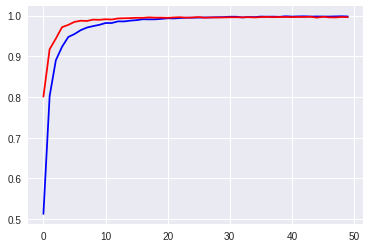

In [14]:
def CNN_final():
    # create model
    model = Sequential()
    
    model.add(Conv2D(16, 3, input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(16, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(250))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    

    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    adam = Adam(lr=0.001)
    model.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])
    return model

# build the model
model = CNN_final()

# Fit the model
t0=time.time()
log = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

plt.plot(log.history['acc'],'b') 
plt.plot(log.history['val_acc'],'r')
plt.show()

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 16)        0         
__________

In [0]:

# import testdata from the local
# the code I used:
#test = []
#test_label = []

#for tpath in test_file:
#    img = plt.imread(tpath)
#    test.append(img)
#    test_label.append(os.path.join(tpath))
# X_test = np.array(test, dtype = 'float32')
# X_test = X_test/255
import h5py
with h5py.File('drive/img/testdata.hdf5','r') as f:
    X_test= f['X'][()] #the [()] means load all data


In [0]:
prediction_final = model.predict(X_test)

In [18]:
print(X_test.shape)

(79726, 64, 64, 3)


Since my test image data on google drive is more than what I have in local drive, I imported the exact length of X_test.

In [0]:
ar = os.listdir('drive/img/test/')[:79726]

In [31]:
len(ar)

79726

In [29]:
ar[79726]

'img_99920.jpg'

In [0]:
import pandas as pd

columns  = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
idxs = ar

df = pd.DataFrame(prediction_final, index=idxs, columns=columns)
df.to_csv('drive/img/driver_df.csv', index=False, header=False, sep=',')

In [36]:
df.to_csv

<bound method DataFrame.to_csv of                       c0        c1        c2        c3        c4        c5  \
img_100047.jpg  0.000580  0.002966  0.019377  0.002944  0.001039  0.963729   
img_100053.jpg  0.002405  0.002864  0.001615  0.005963  0.002988  0.950921   
img_100051.jpg  0.112745  0.031608  0.021100  0.010177  0.020863  0.005709   
img_100049.jpg  0.001515  0.002218  0.000730  0.002946  0.003493  0.002991   
img_100044.jpg  0.016098  0.019025  0.026548  0.691455  0.012984  0.047074   
img_100040.jpg  0.031928  0.032790  0.009638  0.039818  0.020643  0.029344   
img_100043.jpg  0.012719  0.156082  0.014251  0.029964  0.052473  0.031213   
img_10005.jpg   0.087317  0.097281  0.024469  0.049334  0.115613  0.034360   
img_100034.jpg  0.002060  0.002015  0.000631  0.000280  0.000367  0.000466   
img_100033.jpg  0.000136  0.000150  0.000090  0.000115  0.000307  0.000105   
img_10004.jpg   0.167524  0.033928  0.030028  0.047423  0.534266  0.019914   
img_100039.jpg  0.000138  0.00